In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import sys
import matplotlib.pyplot as plt
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [4]:
proj_crs = "EPSG:32630"
place = 'City of Glasgow, United Kingdom'
place_gdf = ox.geocode_to_gdf(place).to_crs(proj_crs)

## Import Data

Data sources:
1. OSM POIs
5. Employment data - find govt source

In [5]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\"

In [6]:
poi_dictionary = {
    'employment':{
        'category':['employment']
    },
    'shopping':{
        'shop':['bakery', 'clothes', 'supermarket', 'mall', 'greengrocer',
                'seafood', 'wine', 'butcher','convenience',
                'beverages', 'alcohol', 'bicycle_shop', 'department_store', 
                'doityourself', 'beauty_shop', 'outdoor_shop', 
                'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                'car_dealership', 'furniture_shop', 'sports_shop',
                'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
        # possibly we could pick up all shop=True excluding a few. but not sure how
        # and many options to exclude
        'amenity':['marketplace'],
        'building':['kiosk', 'supermarket',],
    },
    'errands':{
        'amenity':['atm','bank','courthouse','post_box', 'post_office',
                   'clinic', 'dentist', 'doctors', 'hospital',
                   'pharmacy', 'veterinary', 'travel_agent',
                   'place_of_worship'],
        'shop':['optician', 'hairdresser', 'laundry',],
        'healthcare':['physiotherapist'],
        'office':['government'], #### further refine ?
    },
    'recreation':{
        'leisure':['dog_park', 'ice_rink', 'park', 'pitch', 'playground',
                   "fitness_centre","sports_centre", 'stadium', 'swimming_pool',
                   'swimming_area', 'track', 'water_park','golf_course',],
        'club':['social'],
        'amenity':['bar', 'biergarten', 'cafe', 'fast_food', 'food_court',
                   'ice_cream', 'pub', 'restaurant', 'nightclub',
                   'library', 'arts_centre', 'cinema', 'community_centre',
                   'social_centre', 'theatre',],
        'building':['stadium', 'castle', 'ruins',],
        'tourism':['aquarium', 'artwork', 'attraction', 'gallery',
                   'museum', 'picnic_site', 'theme_park', 'viewpoint',
                   'zoo'],
        'natural':['beach'],
    },
    'education':{
        'amenity':['college', 'kindergarten', 'music_school',
                   'school', 'university', 'childcare'],
    }
}

In [8]:
bbox = place_gdf.unary_union.bounds

In [9]:
bbox

(412863.76118324406, 6182418.064705239, 432921.5645058725, 6198984.441034933)

In [10]:
osm_pois = poi_downloader(place_gdf, poi_dictionary, proj_crs)

In [11]:
employment_centrs = gpd.read_file((folder + 
                        "Walkability\\Other Cities\\Colouring data & results\\Edinburgh Data\\Output Areas w job counts.gpkg"),
                                  ).to_crs(proj_crs)

employment_centrs['category'] = 'employment'
employment_centrs['geometry'] = employment_centrs.geometry.centroid

Need to remove potential overlap between different data sources (and inside some data sources). For now I'm not worrying about this when using only OSM data. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [12]:
pois = pd.concat([osm_pois, employment_centrs])

pois = gpd.clip(pois, place_gdf)

c:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 30N (the single non-null crs provided).
  warnings.warn(


### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [17]:
poi_parameters = pd.read_csv((folder + 
                              "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\poi_parameters_5.csv"),
                            index_col=0)

In [18]:
poi_weights = poi_parameters['weight']

poi_lambdas = poi_parameters['diminishing_returns_constant']

poi_variables = poi_parameters['variable']

poi_nums = poi_parameters['num_pois']

poi_gammas = poi_parameters['distance_constant']

In [19]:
total = sum(poi_weights)
print("total: ", total)

total:  100.00000000000001


In [20]:
poi_variables['employment'] = 'jobs'
poi_nums['employment'] = 1200

C:\Users\z3258367\AppData\Local\Temp\ipykernel_73444\1444990651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_variables['employment'] = 'jobs'
C:\Users\z3258367\AppData\Local\Temp\ipykernel_73444\1444990651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_nums['employment'] = 1200


Reduce the number of decimal places before export, distances do not need to be below 1m.

In [21]:
def result_rounding(results):
    # reduces results size for export
    # score columns such as THERE_Index, employment_23 -> 3 decimal places
    # distance columns such as employment1 -> 0 decimal places (nearest metre)
    # avoid doing anything to connect_id, x or y
    rounding_dict = {**{k:3 for k in results.columns if "_" in k
                        and 'connect_id' not in k},
                     **{k:0 for k in results.columns if "_" not in k
                        and k != 'x'
                        and k != 'y'}}
    return results.round(rounding_dict)

# Walking network

Pandana expects edges to have a two item index based on the same IDs as the node index. (with thanks to https://github.com/shriv/accessibility-series/blob/master/Accounting%20for%20hills%20in%20accessibility%20analyses.ipynb)

In [28]:
G = ox.graph_from_place(place, network_type='walk')

In [29]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [30]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

In [31]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
distance_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

### Pandana network querying. 

In [32]:
walk_dist = 2400

In [33]:
results_walk = there_index(distance_network, pois, poi_dictionary, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance = walk_dist)

Finished category: employment
Maximum score: 0.0 out of 31.9
Finished category: education
Maximum score: 8.883438500488188 out of 14.3
Finished category: shopping
Maximum score: 15.822077813550104 out of 21.6
Finished category: errands
Maximum score: 6.490289060624569 out of 8.9
Finished category: recreation
Maximum score: 17.178255468926533 out of 23.3


In [34]:
max(results_walk['THERE_Index']), np.mean(results_walk['THERE_Index']) #### New

(45.95828762226397, 27.758656800636167)

In [26]:
# old - 85.6, 60.8
#max(results_walk['THERE_Index']), np.mean(results_walk['THERE_Index']) #### New

(85.55739713770453, 60.805788392418556)

In [35]:
small_w_results = gpd.GeoDataFrame(result_rounding(results_walk).drop_duplicates(subset=['x','y']).add_suffix('_walk'), 
                                   geometry = gpd.GeoSeries.from_xy(results_walk.x, results_walk.y, crs=proj_crs))

In [36]:
small_w_results.to_file((folder +
                         "Walkability\\Other Cities\\Colouring data & results\\" + 
                         "Glasgow_walk_270623.gpkg"))

## Cycling

In [18]:
C = ox.graph_from_place(place, network_type='bike')

In [19]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(C)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [20]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

In [21]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
cycle_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

In [30]:
cycle_gammas = poi_gammas.copy()
cycle_gammas = cycle_gammas.replace(to_replace=0.001, value=0.0002)
cycle_dist = 12000

<ipython-input-30-b86ea2175afd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_nums['employment'] = 1200


In [29]:
sum(pois[pois['category']=='employment'].jobs), len(pois[pois['category']=='employment'])

(511251.0, 3974)

### Pandana network querying. 

In [31]:
cycle_results = there_index(cycle_network, pois, poi_dictionary, poi_weights, cycle_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance = cycle_dist)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: employment
Maximum score: 28.980741772852703 out of 31.9


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: education
Maximum score: 13.697803281833789 out of 14.3


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: shopping
Maximum score: 21.48620417302876 out of 21.6


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: errands
Maximum score: 8.853429088088712 out of 8.9


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Finished category: recreation
Maximum score: 23.200015149850245 out of 23.3


In [32]:
max(cycle_results['THERE_Index']), np.mean(cycle_results['THERE_Index'])

(95.31391076813019, 79.04373053509768)

In [297]:
max(results['THERE_Index']), max(cycle_results['THERE_Index'])

(74.3881564759088, 84.92335159776383)

In [298]:
np.mean(results['THERE_Index']), np.mean(cycle_results['THERE_Index'])

(40.695518372495044, 59.09586332339536)

In [190]:
small_c_results = gpd.GeoDataFrame(result_rounding(cycle_results).drop_duplicates(subset=['x','y']).add_suffix('_cycle'), 
                                   geometry = gpd.GeoSeries.from_xy(cycle_results.x, cycle_results.y, crs=proj_crs))

In [395]:
max(small_c_results.jobs)

58043.0

In [34]:
max(small_c_results.jobs)

144663.0

## Driving

In [5]:
D = ox.graph_from_place(place, network_type='drive')

In [6]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(D)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [23]:
edges_gdfs = edges_gdfs.drop(['width', 'highway','length'], axis=1)

In [22]:
edges_gdfs

highway    length  \
u          v          key                            
354026     354785     0    motorway_link  1268.857   
           1764525107 0         motorway  1671.726   
354040     354785     0    motorway_link  2005.053   
           1764669578 0         motorway  2471.157   
354097     354040     0         motorway  4567.979   
...                                  ...       ...   
9804678588 9076199957 0      residential    96.178   
9804678589 9804678588 0      residential    66.268   
9804699015 7089800348 0      residential   221.214   
9804728419 8355860955 0      residential    67.861   
9804728459 7101751270 0      residential    45.553   

                                                                    geometry  \
u          v          key                                                      
354026     354785     0    LINESTRING (-3.41538 55.92543, -3.41506 55.925...   
           1764525107 0    LINESTRING (-3.41538 55.92543, -3.41506 55.925...   
354040     354785     0    LINESTRING (-3.38406 55.92847, -3.38659 55.927...   
           1764669578 0    LINESTRING (-3.38406 55.92847, -3.38497 55.928...   
354097     354040     0    LINESTRING (-3.31986 55.92105, -3.32068 55.920...   
...                                                                      ...   
9804678588 9076199957 0    LINESTRING (-3.30844 55.95800, -3.30854 55.958...   
9804678589 9804678588 0    LINESTRING (-3.30764 55.95839, -3.30844 55.95800)   
9804699015 7089800348 0    LINESTRING (-3.14766 55.89459, -3.14737 55.894...   
9804728419 8355860955 0    LINESTRING (-3.13594 55.89723, -3.13627 55.897...   
9804728459 7101751270 0    LINESTRING (-3.11818 55.92546, -3.11764 55.925...   

                          width  
u          v          key        
354026     354785     0     NaN  
           1764525107 0     NaN  
354040     354785     0     NaN  
           1764669578 0     NaN  
354097     354040     0     NaN  
...                         ...  
9804678588 9076199957 0     NaN  
9804678589 9804678588 0     NaN  
9804699015 7089800348 0     NaN  
9804728419 8355860955 0     NaN  
9804728459 7101751270 0     NaN  

[30708 rows x 4 columns]

In [24]:
edges_gdfs.to_file('Edinburgh drive network.gpkg')

In [102]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

In [103]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
drive_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

In [104]:
poi_nums['employment'] = 1200
drive_gammas = poi_gammas.copy()
drive_gammas = drive_gammas.replace(to_replace=0.001, value=0.0001)
drive_dist = 24000

### Pandana network querying. 

In [105]:
drive_results = there_index(drive_network, pois, poi_dictionary, poi_weights, drive_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance = drive_dist)

Finished category: employment
Maximum score: 29.915538935348426 out of 31.9
Finished category: education
Maximum score: 13.969273727938328 out of 14.3
Finished category: shopping
Maximum score: 21.504332376112938 out of 21.6
Finished category: errands
Maximum score: 8.858566773869837 out of 8.9
Finished category: recreation
Maximum score: 23.200015149850245 out of 23.3


In [106]:
max(drive_results['THERE_Index']), np.mean(drive_results['THERE_Index'])

(97.0675105801912, 89.16878934854581)

In [107]:
max(results['THERE_Index']), max(cycle_results['THERE_Index'])

(94.36550792837683, 95.31391076813019)

In [108]:
np.mean(results['THERE_Index']), np.mean(cycle_results['THERE_Index']), np.mean(drive_results['THERE_Index'])

(75.9478957235696, 79.04373053509768, 89.16878934854581)

In [195]:
small_d_results = gpd.GeoDataFrame(result_rounding(drive_results).drop_duplicates(subset=['x','y']).add_suffix('_drive'), 
                                   geometry = gpd.GeoSeries.from_xy(drive_results.x, drive_results.y, crs=proj_crs))        

In [110]:
max(small_d_results.jobs)

168013.0

In [34]:
max(small_c_results.jobs)

144663.0

## Public Transport

In [35]:
import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

Found feeds on transit land https://www.transit.land/operators?adm1_name=Edinburgh&adm0_name=United%20Kingdom But all the bus and tram ones actually refer to the same source feed which is convenient, although extremely large and slow to process as it includes ~1000 bus operators in the UK.

The train one hasn't been updated since April 2021 but that's the best I can find. Mobility Database Catalogs doesn't have anything useful. Train release data only in CIF format, it appears https://data.atoc.org/how-to https://datafeeds.networkrail.co.uk/ntrod/. Previous data converted by https://planar.network/projects/feeds

In [84]:
bbox = place_gdf.to_crs("EPSG:4326").bounds
bbox_points = (bbox['minx'][0], bbox['miny'][0], bbox['maxx'][0], bbox['maxy'][0])

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=(folder + "Walkability\Other Cities\Colouring data & results\Edinburgh Data\GTFS"), 
                                     validation=True, 
                                     verbose=True, 
                                     bbox=bbox_points, 
                                     remove_stops_outsidebbox=True, 
                                     append_definitions=True)

<>:4: DeprecationWarning: invalid escape sequence \O
<>:4: DeprecationWarning: invalid escape sequence \O
<ipython-input-84-7d8abde32d9b>:4: DeprecationWarning: invalid escape sequence \O
  loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=(folder + "Walkability\Other Cities\Colouring data & results\Edinburgh Data\GTFS"),


Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 21.33 seconds
--------------------------------
Processing GTFS feed: gb-rail-latest
GTFS feed: gb-rail-latest, calendar_dates uses the same service_id across multiple agency_ids. This feed calendar_dates table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: gb-rail-latest, calendar uses the same service_id across multiple agency_ids. This feed calendar table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: gb-rail-latest, stops uses the same stop_id across multiple agency_ids. This feed stops table will be modified from its original format to provide stop_ids for each agency using a one to many join
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned 

Appended route type to stops
Appended route type to stop_times
--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 2.74 seconds
2 GTFS feed file(s) successfully read as dataframes:
     gb-rail-latest
     itm_all_gtfs
     Took 588.03 seconds


In [91]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
10,091 service_ids were extracted from calendar
509,509 trip(s) 46.71 percent of 1,090,770 total trip records were found in calendar for GTFS feed(s): ['gb-rail-latest', 'itm all gtfs']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
509,509 of 1,090,770 total trips were extracted representing calendar day: monday. Took 2.01 seconds
There are no departure time records missing from trips following the specified schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 1.62 seconds
Stop times fro

In [92]:
urbanaccess_net = ua.network.ua_network

In [93]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox_points, remove_lcn=True, network_type='walk')

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](55.81879190,-3.44953260,56.00408370,-3.07495120);>;);out;'}"


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnet\load.py:237: DeprecationWarning: Flags not at the start of the expression '//(?s)(.*?)/'
  domain = re.findall(r'//(?s)(.*?)/', url)[0]


Downloaded 37,564.5KB from www.overpass-api.de in 4.39 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 5.09 seconds
Returning OSM data with 267,185 nodes and 51,337 ways...
Edge node pairs completed. Took 40.27 seconds
Returning processed graph with 63,541 nodes and 169,598 edges...
Completed OSM data download and Pandana node and edge table creation in 48.40 seconds
checking for low connectivity nodes...
147 out of 63,541 nodes (0.23 percent of total) were identified as having low connectivity and have been removed.
Completed OSM data download and graph node and edge table creation in 151.08 seconds


In [94]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


In [96]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False)

Loaded UrbanAccess network components comprised of:
     Transit: 3,246 nodes and 56,422 edges;
     OSM: 63,394 nodes and 169,382 edges
Connector edges between the OSM and transit network nodes successfully completed. Took 1.86 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 2.38 seconds
Network edge and node network integration completed successfully resulting in a total of 66,640 nodes and 232,296 edges:
     Transit: 3,246 nodes 56,422 edges;
     OSM: 63,394 nodes 169,382 edges; and
     OSM/Transit connector: 6,492 edges.


In [98]:
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

Stop times from 07:00:00 to 10:00:00 successfully selected 58,452 records out of 324,190 total records (18.03 percent of total). Took 0.02 seconds
Starting route stop headway calculation for 6,968 route stops...
Route stop headway calculation complete. Took 9.66 seconds
headway calculation complete. Took 12.05 seconds


In [100]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 3,246 nodes and 56,422 edges;
     OSM: 63,394 nodes and 169,382 edges
routes successfully joined to transit nodes. Took 0.07 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 2.17 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.04 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 1.77 seconds
Network edge and node network integration completed successfully resulting in a total of 70,344 nodes and 291,023 edges:
     Transit: 6,950 nodes 56,422 edges;
     OSM: 63,394 nodes 169,382 edges; and
     OSM/Transit connector: 65,219 edges.


In [101]:
ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename='Edinburgh_integrated_net.h5',
                        overwrite_key = True)

Using existing data/Edinburgh_integrated_net.h5 hdf5 store.
Existing edges overwritten in data/Edinburgh_integrated_net.h5 hdf5 store.
Using existing data/Edinburgh_integrated_net.h5 hdf5 store.
Existing nodes overwritten in data/Edinburgh_integrated_net.h5 hdf5 store.


### Start here if transit & pedestrian integrated network saved previously

In [37]:
urbanaccess_net = ua.network.load_network(filename='Edinburgh_integrated_net.h5')

Successfully read store: data/Edinburgh_integrated_net.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/Edinburgh_integrated_net.h5 with the following keys: ['/edges', '/nodes']


In [38]:
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)

In [39]:
wgs_pois = pois.to_crs("EPSG:4326")

In [40]:
transit_max_time = 60

In [41]:
# need to change the distance/time decay
transit_gammas = poi_gammas.copy()
transit_gammas = transit_gammas.replace(to_replace=0.001, value=0.025)

In [42]:
results = there_index(transit_ped_net, wgs_pois, poi_dictionary, poi_weights, transit_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=transit_max_time)

Finished category: employment
Maximum score: 29.375287530264536 out of 31.9
Finished category: education
Maximum score: 13.468278667272031 out of 14.3
Finished category: shopping
Maximum score: 21.41572577820941 out of 21.6
Finished category: errands
Maximum score: 8.844842604898927 out of 8.9
Finished category: recreation
Maximum score: 23.197520842794535 out of 23.3


In [137]:
max(results.THERE_Index), np.mean(results.THERE_Index)

(85.52728927708813, 57.237315723986256)

In [43]:
# new version
max(results.THERE_Index), np.mean(results.THERE_Index)

(94.36550792837683, 75.9478957235696)

In [146]:
results

,x,y,jobs,employment1,employment2,employment3,employment4,employment5,employment_31.9,education1,...,errands4,errands5,errands_8.9,recreation1,recreation2,recreation3,recreation4,recreation5,recreation_23.3,THERE_Index
id_int,,,,,,,,,,,,,,,,,,,,,
1,-3.432510,55.888690,119432.409199,8.018,8.483,8.636,8.967,9.015,27.470050,11.190,...,8.331,9.920,7.143254,7.042,8.582,9.015,9.255,9.602,18.585779,79.947615
2,-3.318750,55.900570,131993.225326,4.018,4.483,4.636,4.967,5.015,28.300633,7.190,...,4.331,5.920,7.894517,3.042,4.582,5.015,5.255,5.602,20.540463,86.297311
3,-3.243460,55.926690,138564.197476,0.636,4.168,4.168,5.304,5.304,28.671105,6.655,...,4.027,4.077,8.021427,3.947,3.947,3.947,4.077,4.441,20.879994,88.182403
4,-3.218450,55.945810,147325.206995,2.607,2.663,2.887,3.400,3.706,29.106430,3.183,...,0.787,1.707,8.632049,0.475,0.475,0.475,0.605,0.969,22.764071,93.243614
5,-3.307660,55.927550,135942.509831,4.192,7.607,7.663,7.887,8.400,28.528100,8.183,...,5.605,5.605,7.724706,0.613,2.608,3.934,4.033,5.475,21.347911,87.900404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70340,-3.151680,55.959993,94912.789557,0.391,0.856,1.209,2.243,2.266,25.256110,2.841,...,3.652,3.869,8.146791,0.010,1.770,2.072,2.266,2.266,22.004738,86.441127
70341,-3.151749,55.960011,94914.560033,0.333,0.914,1.151,2.301,2.324,25.256305,2.783,...,3.710,3.811,8.150967,0.068,1.712,2.130,2.324,2.324,21.995201,86.449404
70342,-3.151757,55.960013,94918.450325,0.327,0.920,1.145,2.307,2.330,25.256732,2.777,...,3.716,3.805,8.151400,0.074,1.706,2.136,2.330,2.330,21.994253,86.450825


In [193]:
small_pt_results = gpd.GeoDataFrame(result_rounding(results).drop_duplicates(subset=['x','y']).add_suffix('_transit'), 
                                    geometry = gpd.GeoSeries.from_xy(results.x, results.y, crs="EPSG:4326")).to_crs(proj_crs)

## Export results

In [22]:
small_results = gpd.GeoDataFrame(result_rounding(results), geometry = gpd.GeoSeries.from_xy(results.x, results.y, crs=proj_crs))

NameError: name 'results' is not defined

In [ ]:
small_pt_results.to_file((folder +
                         "Walkability\\Other Cities\\Colouring data & results\\Edinburgh Data\\" + 
                         "Edinburgh_pt_170622.gpkg"))

In [ ]:
small_c_results.to_file((folder +
                         "Walkability\\Other Cities\\Colouring data & results\\Edinburgh Data\\" + 
                         "Edinburgh_cycle_170622.gpkg"))

### Import population for population weighted results

In [25]:
population = pd.read_csv((folder + 
                        "Walkability\\Other Cities\\Colouring data & results\\Edinburgh Data\\KS101SC - Usual resident population.csv"),
                            index_col=0)

In [26]:
population

,All people,Males,Females,Lives in a household,Lives in a communal establishment,Schoolchild or full-time student aged 4 and over at their non term-time address,Area (hectares),Density (number of persons per hectare)
Output Area,,,,,,,,
Scotland,"5,295,403","2,567,444","2,727,959","5,196,386","99,017","41,551","7,793,711",0.68
S00088956,230,111,119,230,-,1,8,28.13
S00088957,66,33,33,66,-,1,213,0.31
S00088958,90,38,52,90,-,2,3,26.57
S00088959,83,44,39,83,-,-,238,0.35
...,...,...,...,...,...,...,...,...
S00135302,128,65,63,128,-,5,"2,826",0.05
S00135303,81,39,42,81,-,-,521,0.16
S00135304,81,41,40,81,-,5,"2,431",0.03


Join to Output Areas by name. Used population weighted centroids available from Government. Join to the closest result point. Get average, distribution and export these centroids for further visualisation.

In [27]:
output_areas = gpd.read_file(folder +
                             "Walkability\\Other Cities\\Colouring data & results\\Edinburgh Data\\OutputArea2011_PWC.shp")

In [28]:
output_areas = output_areas.join(population, on='code')

In [29]:
output_areas = output_areas.to_crs(proj_crs)

In [30]:
output_areas['All people'] = output_areas['All people'].str.replace(',','').astype(int)

In [31]:
output_areas = output_areas.clip(place_gdf)

In [ ]:
output_areas_pt = output_areas.sjoin_nearest(small_pt_results.to_crs(proj_crs), how='left',rsuffix='transit')

In [197]:
output_areas_c = output_areas_pt.sjoin_nearest(small_c_results, how='left',rsuffix='cycle')

In [198]:
output_areas_d = output_areas_c.sjoin_nearest(small_d_results, how='left',rsuffix='drive')

In [199]:
output_areas_w = output_areas_d.sjoin_nearest(small_w_results, how='left')

In [32]:
output_areas = output_areas.sjoin_nearest(small_w_results, how='left')

In [33]:
sum(output_areas['All people']*output_areas['THERE_Index_walk'])/sum(output_areas['All people'])

47.21447057651063

In [41]:
sum(output_areas['All people'])

476626

In [202]:
sum(output_areas_c['All people']*output_areas_c['THERE_Index_transit'])/sum(output_areas_c['All people'])

83.58765366345939

In [203]:
sum(output_areas_c['All people']*output_areas_c['THERE_Index_cycle'])/sum(output_areas_c['All people'])

84.08980383990789

In [205]:
sum(output_areas_w['All people']*output_areas_w['THERE_Index_drive'])/sum(output_areas_w['All people'])

91.1811202137527

In [206]:
sum(output_areas_w['All people']*output_areas_w['THERE_Index_walk'])/sum(output_areas_w['All people'])

48.29506182835168

Text(0.5, 0.98, 'Edinburgh: distribution of results by residential population')

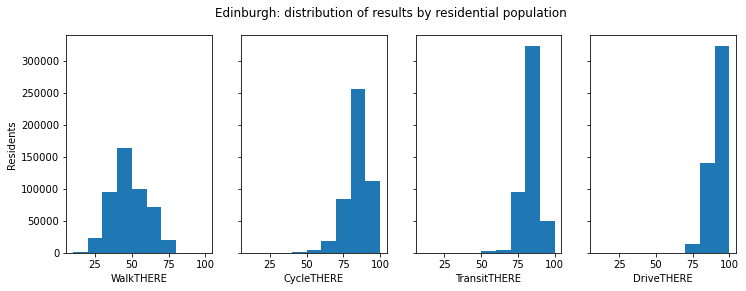

In [217]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12, 4))
bins=[10,20,30,40,50,60,70,80,90,100]
ax1.hist(output_areas_w['THERE_Index_walk'], weights = output_areas_w['All people'], bins=bins)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')
ax2.hist(output_areas_w['THERE_Index_cycle'], weights = output_areas_w['All people'], bins=bins)
ax2.set_xlabel('CycleTHERE')
ax3.hist(output_areas_w['THERE_Index_transit'], weights = output_areas_w['All people'], bins=bins)
ax3.set_xlabel('TransitTHERE')
ax4.hist(output_areas_w['THERE_Index_drive'], weights = output_areas_w['All people'], bins=bins)
ax4.set_xlabel('DriveTHERE')
fig.suptitle('Edinburgh: distribution of results by residential population')

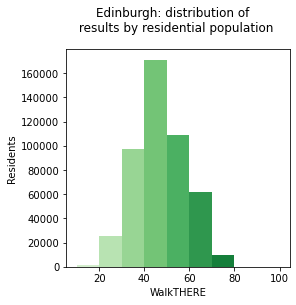

In [35]:
cm = plt.cm.Greens
bins=[10,20,30,40,50,60,70,80,90,100]
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
fig.set_figwidth(4)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')
fig.suptitle('Edinburgh: distribution of \n results by residential population',va='center')

n, bins, patches = plt.hist(output_areas['THERE_Index_walk'], weights = output_areas['All people'], label='WalkTHERE',bins=bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/10 + 0.2)) # notice the i/25
    
plt.show()
fig.savefig('Edinburgh_dist_walk_170822.eps', format='eps')

In [37]:
output_areas.to_file((folder +
                         "Walkability\\Other Cities\\Colouring data & results\\Edinburgh Data\\" + 
                         "Edinburgh_OA_walk_results_241022.gpkg"))

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


In [216]:
output_areas_w[output_areas_w['THERE_Index_transit'] > output_areas_w['THERE_Index_drive']]

,OBJECTID,code,masterpc,easting,northing,geometry,All people,Males,Females,Lives in a household,...,errands4_walk,errands5_walk,errands_8.9_walk,recreation1_walk,recreation2_walk,recreation3_walk,recreation4_walk,recreation5_walk,recreation_23.3_walk,THERE_Index_walk
28711,28712,S00105971,EH14 7EJ,316388,666035,POINT (478850.039 6192795.524),171,87,84,171,...,400.0,446.0,6.441,344.0,446.0,447.0,472.0,479.0,14.912,35.273
40925,40926,S00106496,EH30 9QP,313215,677667,POINT (475509.540 6204379.001),172,83,89,172,...,379.0,417.0,6.242,182.0,211.0,211.0,305.0,314.0,17.750,42.529
27245,27246,S00106508,EH30 9JW,313503,677951,POINT (475793.360 6204667.102),130,62,68,130,...,551.0,724.0,5.510,229.0,263.0,263.0,269.0,313.0,17.476,41.223
388,389,S00106479,EH30 9XB,311994,677986,POINT (474284.210 6204680.289),179,98,81,179,...,665.0,968.0,5.845,212.0,259.0,667.0,667.0,750.0,14.188,31.816
28404,28405,S00106478,EH30 9XX,312312,678005,POINT (474601.860 6204703.881),221,107,114,221,...,595.0,843.0,5.192,220.0,595.0,701.0,721.0,721.0,13.236,30.840
36201,36202,S00107579,EH30 9LE,313669,678161,POINT (475956.281 6204879.456),144,72,72,144,...,646.0,937.0,4.739,249.0,317.0,386.0,434.0,457.0,15.834,34.776
38406,38407,S00106680,EH30 9TA,313608,678310,POINT (475893.138 6205027.544),57,26,31,56,...,597.0,695.0,6.085,96.0,105.0,105.0,128.0,168.0,19.799,41.015
